# Final Project Week 2 - Battle of the Neighborhoods
## IBM Data Science, Coursera, August 2020

### Table of Contents 
* [1. Introduction: Business Problem](#introduction)
* [2. Data Description and Sources](#data)
* [3. Methodology and Analysis](#methodology)
* [4. Results and Discussion](#results)
* [5. Conclusion](#conclusion)

### 1. Introduction <a name="introduction"></a>
___

In this hypothetical scenario, we are working with a restauranteur client in discussing the **optimal neighborhood to open a new restaurant in Manhattan.** The operator would like to know which neighborhood would lead to the highest likelihood of a successful new restaurant launch based on numerous factors including **existing restaurants and their respective ratings/success in that neighborhood, and demographic data of the people who live in those neighborhoods.** Our restauranteur client is leaning towards opening an **Italian restaurant,** despite the healthy level of competition for those in the city. 

### 2. Description of Data <a name="data"></a>
___

To undertake the analysis requested by our client, we will be used data from several sources including the below: 

**1. Foursquare data accessed through the Foursquare API**
  * Foursquare's Places API allows access to their Global database with real-time access to over 105 million places across 190 countries and 50 territories.
  * The database containes over 70+ attributes for each venue (location of interest), and 900+ categories, based on crowdsourced information collected from the community 
  * The data from this database will be used to help solve the question asked by the restauranteur in that we will use the data to analyze the existing restaurants in each neighborhood, and their respective success (by looking at customer ratings), and to cluster similar neighborhoods by most common venues in those neighborhoods. 
 
 
**2. NYC OpenData for populuation across neighborhood tabulation areas**
  * This data is collected by NYC from the census bureau's decennial data dissemination. Neighborhood tabulation areas (NTAs) are aggregations of census tracts that are subsets of NYC's 55 Public Use Microdata Areas (PUMAs). 
  * The data reflects the change in population from 2000 to 2010 for each NTA. 
  * We will use this data on two fronts: first, to see which neighborhoods are growing more rapidly in terms of population and which ones are declining, if any, and second, we will use the data to calculate the density of restaurants per capita for additional metrics when running the clustering algorithm, in conjunction with the Foursquare data above.
  
  
**3. RentHop data from a study posted in July 2017 studying affordability of neighborhoods in New York.**
  * This data compiled by RentHop consists of median income levels and median rents for 2BR apartments, by neighborhood for NYC. 
  * We will use this data to assess which neighborhoods have high levels of median household income, as well as affordability (defined as % of income that goes towards rent), as those items will also be important characteristics when clustering neighborhoods when combined with the data from the other two sources above. 

**In the following section we will be loading the necessary data for the analysis.**

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import json
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
print('Libraries Imported!')

Libraries Imported!


In [2]:
# Pull in NYC neighborhood data provided in Week 3 lab

filename = 'newyork_data.json'
with open(filename) as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods = newyork_data['features'] # only data we care about is in the features section 

neighborhoods[0] # show first datapoint to check to make sure we got it correctly

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [4]:
# turn imported json file into a Pandas dataframe so we can work with it in sklearn later

# define an empty dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods_df = pd.DataFrame(columns=column_names)

for data in neighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_df = neighborhoods_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
neighborhoods_df.shape # Provided data has 306 neighborhoods for NYC

(306, 4)

In [13]:
# Drop everything other than Manhattan neighborhoods, which are the scope of this project

dropIndex = neighborhoods_df[neighborhoods_df['Borough'] != "Manhattan"].index
manhattan_neighborhoods = neighborhoods_df.drop(dropIndex, inplace = False)
print("There are this many neighborhoods in Manhatthan: ", manhattan_neighborhoods.shape[0])
manhattan_neighborhoods.reset_index(inplace = True)
manhattan_neighborhoods = manhattan_neighborhoods[['Borough','Neighborhood','Latitude','Longitude']]
manhattan_neighborhoods.head()

There are this many neighborhoods in Manhatthan:  40


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Load demographic data from NYC OpenData (downloaded to local directory as .csv from the following link):
https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp

In [5]:
# Load CSV into a pandas dataframe

filename2 = 'New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv'
pop = pd.read_csv(filename2)
pop.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,"28,149"
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,"35,422"
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,"55,329"
3,Bronx,2000,5,BX06,Belmont,"25,967"
4,Bronx,2000,5,BX07,Bronxdale,"34,309"


In [14]:
# Drop non-Manhattan neighborhoods and other unnecessary columns (NTA Code and FIPS County Code)

dropIndexes = pop[pop['Borough'] != 'Manhattan'].index
manhattanPopData = pop.drop(dropIndexes, inplace = False)
manhattanPopData.reset_index(inplace = True)
manhattanPopData = manhattanPopData[['Borough', 'Year', 'NTA Name', 'Population']]
manhattanPopData.head()

,Borough,Year,NTA Name,Population
0,Manhattan,2000,Marble Hill-Inwood,"49,087"
1,Manhattan,2000,Central Harlem North-Polo Grounds,"70,016"
2,Manhattan,2000,Hamilton Heights,"50,555"
3,Manhattan,2000,Manhattanville,"24,772"
4,Manhattan,2000,Morningside Heights,"54,208"


In [64]:
# Note that the source data has population as of 2000 and 2010 but all in the same table.
# We want to turn this into a dataframe where 2000 and 2010 are separate columns 

temp2000 = manhattanPopData[manhattanPopData['Year'] == 2000]
temp2010 = manhattanPopData[manhattanPopData['Year'] == 2010]
temp2000 = temp2000.rename(columns = {'Year' : '2000'})
temp2010 = temp2010.rename(columns = {'Year' : '2010'})
merged = pd.merge(temp2000, temp2010, on = 'NTA Name')

# Rename the columns from the dataframe above and print shape

manhattanPopulation = merged[['Borough_x','NTA Name','Population_x','Population_y']]
manhattanPopulation = manhattanPopulation.rename(columns = {'Borough_x':'Borough','Population_x':'2000 Pop.','Population_y':'2010 Pop.'})
print('This data set has ',manhattanPopulation.shape[0],' neighborhoods in it.')

# turn strings into integers for population data and calculate growth rate
manhattanPopulation['2000 Pop.'] = manhattanPopulation['2000 Pop.'].str.replace(',','')
manhattanPopulation['2010 Pop.'] = manhattanPopulation['2010 Pop.'].str.replace(',','')
manhattanPopulation['2000 Pop.'] = manhattanPopulation['2000 Pop.'].astype(int)
manhattanPopulation['2010 Pop.'] = manhattanPopulation['2010 Pop.'].astype(int)

manhattanPopulation['Growth Rate %'] = (manhattanPopulation['2010 Pop.'] / manhattanPopulation['2000 Pop.']).add(-1)*100

manhattanPopulation.head()

This data set has  29  neighborhoods in it.


,Borough,NTA Name,2000 Pop.,2010 Pop.,Growth Rate %
0,Manhattan,Marble Hill-Inwood,49087,46746,-4.769083
1,Manhattan,Central Harlem North-Polo Grounds,70016,75282,7.521138
2,Manhattan,Hamilton Heights,50555,48520,-4.025319
3,Manhattan,Manhattanville,24772,22950,-7.355078
4,Manhattan,Morningside Heights,54208,55929,3.174808


#### **Notice that there are only 29 Manhattan neighborhoods in this NYC OpenData data set compared to 40 from the coordinate data. We will address this in a later step to consolidate neighborhoods to match the 29 from NYC OpenData. First we will load the final data source from RentHop to obtain median income data points.**

Load income and rent information RentHop data sourced from here: https://www.renthop.com/studies/nyc/can-you-afford-to-live-in-new-york

Downloaded into CSV and saved in local directory.

In [66]:
filename3 = 'RentHop_Data.csv'

income = pd.read_csv(filename3)
income.drop(columns = ['Income % for Rent','Income Required to Lease (40X Rule)'], inplace = True) # drop unneeded columns
income.head()

,Neighborhood,Borough,Two BR Median Rent,Median Household Income
0,Queensbridge-Ravenswood-Long Island City,Queens,"3,300","28,378"
1,Williamsburg,Brooklyn,"2,499","21,502"
2,Lower East Side,Manhattan,"3,495","31,273"
3,Mott Haven-Port Morris,Bronx,"2,200","20,334"
4,East Harlem North,Manhattan,"2,495","26,099"


In [77]:
# Convert columns to int
income['Two BR Median Rent'] = income['Two BR Median Rent'].astype(int)
income['Median Household Income'] = income['Median Household Income'].astype(int)

# merge with population data from previous steps
# Important to Note: this only works because the RentHop data uses the same NTAs for neighborhoods.
# the only NTA that RentHop excludes is MN99, which represents Central Park and will be dropped from the final dataset
tempPop = manhattanPopulation.rename(columns = {'NTA Name':'Neighborhood'})
tempPop.head()
merged2 = pd.merge(tempPop, income, on='Neighborhood')

neighborhood_df = merged2[['Neighborhood','2000 Pop.','2010 Pop.','Growth Rate %','Two BR Median Rent','Median Household Income']]
dropParks = neighborhood_df[neighborhood_df['Neighborhood'] == 'park-cemetery-etc-Manhattan'].index
neighborhood_df = neighborhood_df.drop(dropParks)
print('There are ',neighborhood_df.shape[0],' neighborhoods in this Manhattan dataset')

neighborhood_df.head()

There are  28  neighborhoods in this Manhattan dataset


,Neighborhood,2000 Pop.,2010 Pop.,Growth Rate %,Two BR Median Rent,Median Household Income
0,Marble Hill-Inwood,49087,46746,-4.769083,2200,39003
1,Central Harlem North-Polo Grounds,70016,75282,7.521138,2300,34413
2,Hamilton Heights,50555,48520,-4.025319,2495,39019
3,Manhattanville,24772,22950,-7.355078,2550,29182
4,Morningside Heights,54208,55929,3.174808,3200,56371


#### The final step in processing the neighborhood data before querying the Foursquare API is to make sure that the 40 neighborhoods from the data provided in the Week 3 Lab json file are mapped to the 28 Manhattan Neighborhood Tabulation Areas (NTAs) (note: excludes the park-cemetary NTA corresponding to primarily Central Park and other parks/non-residential area) used by RentHop and NYC OpenData.

We will do this by creating a dictionary-like object that contains the mapping of 40 neighborhoods to the 28 final NTAs that we will feed to Foursquare.

In [144]:
# create two iterable list objects based on the two dataframes created in previous steps and an empty dictionary

keys = neighborhood_df['Neighborhood'].tolist()
values = manhattan_neighborhoods['Neighborhood'].tolist()
neighborhood_map = {}

for i in keys:
    split = i.split('-')
    split_lower = list(map(lambda x: x.lower(),split))
    temp = []
    for j in values:
        if (j.lower() in split_lower):
            temp.append(j)
    neighborhood_map[i] = temp
    
neighborhood_map         

{'Marble Hill-Inwood': ['Marble Hill', 'Inwood'],
 'Central Harlem North-Polo Grounds': [],
 'Hamilton Heights': ['Hamilton Heights'],
 'Manhattanville': ['Manhattanville'],
 'Morningside Heights': ['Morningside Heights'],
 'Central Harlem South': [],
 'Upper West Side': ['Upper West Side'],
 'Hudson Yards-Chelsea-Flat Iron-Union Square': ['Chelsea', 'Hudson Yards'],
 'Lincoln Square': ['Lincoln Square'],
 'Clinton': ['Clinton'],
 'Midtown-Midtown South': ['Midtown', 'Midtown South'],
 'Turtle Bay-East Midtown': ['Turtle Bay'],
 'Murray Hill-Kips Bay': ['Murray Hill'],
 'Gramercy': ['Gramercy'],
 'East Village': ['East Village'],
 'West Village': ['West Village'],
 'SoHo-TriBeCa-Civic Center-Little Italy': ['Tribeca',
  'Little Italy',
  'Soho',
  'Civic Center'],
 'Battery Park City-Lower Manhattan': ['Battery Park City'],
 'Chinatown': ['Chinatown'],
 'Lower East Side': ['Lower East Side'],
 'Lenox Hill-Roosevelt Island': ['Lenox Hill', 'Roosevelt Island'],
 'Yorkville': ['Yorkville'

The above is almost complete with a few exceptions that will be manually cleaned up in the following cell. 
  * Flat Iron was two words in the key list and did not match with the neighborhoods list spelling of Flatiron. 
  * Neighborhoods that are bifurcated into North/South, East/West including: Central Harlem (N+S), East Harlem (N+S) and Washington Heights (N+S) were not mapped and will be manually added.
  * Financial District, Greenwich Village, Manhattan Valley, Noho, Sutton Place and Tudor City were skipped as there is no neighborhood from the master list which contains those words.

In [145]:
# Manual fixes for the above.

def add_manually(map_name, to_add):
    curr_list = neighborhood_map[map_name]
    if curr_list is None:
        neighborhood_map[map_name] = to_add
    else: 
        curr_list = curr_list + to_add
        neighborhood_map[map_name] = curr_list
        
add_manually('Central Harlem North-Polo Grounds',['Central Harlem'])
add_manually('Upper West Side',['Manhattan Valley'])
add_manually('Turtle Bay-East Midtown',['Sutton Place', 'Tudor City'])
add_manually('West Village',['Greenwich Village', 'Noho'])
add_manually('Battery Park City-Lower Manhattan',['Financial District'])
add_manually('East Harlem South',['East Harlem'])
add_manually('Washington Heights North',['Washington Heights'])
neighborhood_map


{'Marble Hill-Inwood': ['Marble Hill', 'Inwood'],
 'Central Harlem North-Polo Grounds': ['Central Harlem'],
 'Hamilton Heights': ['Hamilton Heights'],
 'Manhattanville': ['Manhattanville'],
 'Morningside Heights': ['Morningside Heights'],
 'Central Harlem South': [],
 'Upper West Side': ['Upper West Side', 'Manhattan Valley'],
 'Hudson Yards-Chelsea-Flat Iron-Union Square': ['Chelsea', 'Hudson Yards'],
 'Lincoln Square': ['Lincoln Square'],
 'Clinton': ['Clinton'],
 'Midtown-Midtown South': ['Midtown', 'Midtown South'],
 'Turtle Bay-East Midtown': ['Turtle Bay', 'Sutton Place', 'Tudor City'],
 'Murray Hill-Kips Bay': ['Murray Hill'],
 'Gramercy': ['Gramercy'],
 'East Village': ['East Village'],
 'West Village': ['West Village', 'Greenwich Village', 'Noho'],
 'SoHo-TriBeCa-Civic Center-Little Italy': ['Tribeca',
  'Little Italy',
  'Soho',
  'Civic Center'],
 'Battery Park City-Lower Manhattan': ['Battery Park City',
  'Financial District'],
 'Chinatown': ['Chinatown'],
 'Lower East Sid

In [183]:
# Combine Neighborhood data with neighborhood coordinates using the neighborhood_map dictionary
# in the case of there being more than one neighborhood mapped to the master key, average the coordinates 

coord_lookup = manhattan_neighborhoods.set_index('Neighborhood')

def avg_coordinate(neighborhood_list): # function will take in a list of neighborhoods and return the average coordinate
    counter = 0
    lat_sum = 0
    long_sum = 0
    for i in neighborhood_list:
        counter += 1
        lat_sum += coord_lookup.loc[i,'Latitude']
        long_sum += coord_lookup.loc[i,'Longitude']
    return (lat_sum / counter, long_sum / counter)

neighborhood_master_df = neighborhood_df
neighborhood_master_df['Latitude'] = '' # create empty columns for coordinate data
neighborhood_master_df['Longitude'] = ''

# create dictionary using the neighborhood map before that contains the average coordinate using the function above
neighborhood_map_coord = {}
for key, values in neighborhood_map.items():
    if (values != []):
        neighborhood_map_coord[key] = avg_coordinate(values)
    else:
        neighborhood_map_coord[key] = [0,0]
 

In [271]:
# set Lat and Long in master neighborhood df using the dictionary created in the previous cell

for i in range(0,neighborhood_master_df.shape[0]):
    neighborhood = neighborhood_master_df.loc[i,'Neighborhood']
    lat = neighborhood_map_coord[neighborhood][0]
    long = neighborhood_map_coord[neighborhood][1]
    neighborhood_master_df.loc[i,'Latitude'] = lat
    neighborhood_master_df.loc[i,'Longitude'] = long

# Drop Central Harlem South, East Harlem North and Washington Heights South due to not having distinct coordinate data
neighborhood_master_df = neighborhood_master_df[neighborhood_master_df['Latitude'] != 0]
neighborhood_master_df.reset_index(inplace = True)
neighborhood_master_df.drop(columns=["index"], inplace = True)

rent_proportion = neighborhood_master_df['Two BR Median Rent'] / neighborhood_master_df['Median Household Income']
neighborhood_master_df['Rent % of Income'] = rent_proportion
    
neighborhood_master_df


,Neighborhood,2000 Pop.,2010 Pop.,Growth Rate %,Two BR Median Rent,Median Household Income,Latitude,Longitude,Rent % of Income
0,Marble Hill-Inwood,49087,46746,-4.769083,2200,39003,40.8721,-73.9159,0.056406
1,Central Harlem North-Polo Grounds,70016,75282,7.521138,2300,34413,40.816,-73.9432,0.066835
2,Hamilton Heights,50555,48520,-4.025319,2495,39019,40.8236,-73.9497,0.063943
3,Manhattanville,24772,22950,-7.355078,2550,29182,40.8169,-73.9574,0.087383
4,Morningside Heights,54208,55929,3.174808,3200,56371,40.808,-73.9639,0.056767
5,Upper West Side,136954,132378,-3.341268,3980,92268,40.7925,-73.9707,0.043135
6,Hudson Yards-Chelsea-Flat Iron-Union Square,55839,70150,25.629041,4304,101369,40.7503,-74.0016,0.042459
7,Lincoln Square,55239,61489,11.314470,5233,120337,40.7735,-73.9853,0.043486
8,Clinton,40595,45884,13.028698,3600,73591,40.7591,-73.9961,0.048919
9,Midtown-Midtown South,25807,28630,10.938893,3950,114491,40.7516,-73.9852,0.034501


Now that we have a Pandas dataframe containing neighborhood name, pop. and pop. growth, median income data and coordinates, we are ready to pull in venue data from the Foursquare API. 

In [209]:
# Define Foursquare Credential 

CLIENT_ID = 'I5YXGXQ3KYOJFQES4NIAHA4KZVEQ3EYZANTLSS13C53DCGCU' # your Foursquare ID
CLIENT_SECRET = 'O014N4MJ3ESMMTELKOQOCZG4X50LANMOCTJBAPKVY5IP11UT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 150

In [210]:
# Function that extracts the category of the venue from JSON data returned by Foursquare API call 

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Function for neighborhoods 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'FSQ ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [211]:
# Code to find venues in Manhattan

manhattan_venues = getNearbyVenues(names=neighborhood_master_df['Neighborhood'], latitudes=neighborhood_master_df['Latitude'], longitudes=neighborhood_master_df['Longitude'])
manhattan_venues.head()

Marble Hill-Inwood
Central Harlem North-Polo Grounds
Hamilton Heights
Manhattanville
Morningside Heights
Upper West Side
Hudson Yards-Chelsea-Flat Iron-Union Square
Lincoln Square
Clinton
Midtown-Midtown South
Turtle Bay-East Midtown
Murray Hill-Kips Bay
Gramercy
East Village
West Village
SoHo-TriBeCa-Civic Center-Little Italy
Battery Park City-Lower Manhattan
Chinatown
Lower East Side
Lenox Hill-Roosevelt Island
Yorkville
East Harlem South
Washington Heights North
Upper East Side-Carnegie Hill
Stuyvesant Town-Cooper Village


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,FSQ ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill-Inwood,40.872117,-73.915935,49caa774f964a520d1581fe3,Indian Road Café,40.872922,-73.918459,Café
1,Marble Hill-Inwood,40.872117,-73.915935,4bce0773c564ef3b6686edf0,Baker Athletic Complex,40.872061,-73.914876,Athletics & Sports
2,Marble Hill-Inwood,40.872117,-73.915935,4bebf782a9900f47fb5c1840,Park Terrace Deli,40.871335,-73.914450,Deli / Bodega
3,Marble Hill-Inwood,40.872117,-73.915935,5830ff3044587f7beb2271cc,Guacamole,40.869659,-73.916736,Mexican Restaurant
4,Marble Hill-Inwood,40.872117,-73.915935,49fe029cf964a5205d6f1fe3,Inwood Hill Park,40.870858,-73.920129,Park


In [212]:
print(manhattan_venues.shape)
manhattan_venues.groupby('Neighborhood').count()

(1916, 8)


,Neighborhood Latitude,Neighborhood Longitude,FSQ ID,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Battery Park City-Lower Manhattan,100,100,100,100,100,100,100
Central Harlem North-Polo Grounds,43,43,43,43,43,43,43
Chinatown,100,100,100,100,100,100,100
Clinton,100,100,100,100,100,100,100
East Harlem South,39,39,39,39,39,39,39
East Village,100,100,100,100,100,100,100
Gramercy,91,91,91,91,91,91,91
Hamilton Heights,63,63,63,63,63,63,63
Hudson Yards-Chelsea-Flat Iron-Union Square,82,82,82,82,82,82,82


In [201]:
print('There are {} unique categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 277 unique categories.


In [202]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill-Inwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill-Inwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill-Inwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill-Inwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill-Inwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City-Lower Manhattan,0.010000,0.000000,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.030000,0.00,0.010000,0.000000
1,Central Harlem North-Polo Grounds,0.000000,0.069767,0.046512,0.000000,0.000000,0.023256,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
2,Chinatown,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.00,0.00,0.02,...,0.000000,0.00,0.040000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.010000
3,Clinton,0.000000,0.000000,0.040000,0.000000,0.000000,0.010000,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.020000,0.030000,0.00,0.000000,0.000000
4,East Harlem South,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
5,East Village,0.000000,0.000000,0.020000,0.010000,0.010000,0.010000,0.00,0.01,0.00,...,0.000000,0.00,0.030000,0.000000,0.00,0.030000,0.010000,0.01,0.000000,0.000000
6,Gramercy,0.000000,0.000000,0.043956,0.000000,0.000000,0.010989,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.010989,0.00,0.000000,0.010989
7,Hamilton Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.016129,0.000000,0.00,0.000000,0.032258
8,Hudson Yards-Chelsea-Flat Iron-Union Square,0.000000,0.000000,0.000000,0.000000,0.012048,0.168675,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.012048,0.012048,0.00,0.000000,0.000000
9,Lenox Hill-Roosevelt Island,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.023256,0.00,0.000000,0.023256,0.00,0.000000,0.000000


In [204]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [205]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City-Lower Manhattan,Hotel,Park,Memorial Site,Coffee Shop,Pizza Place,Wine Shop,Gym,Food Truck,Plaza,Gourmet Shop
1,Central Harlem North-Polo Grounds,African Restaurant,American Restaurant,Chinese Restaurant,Cosmetics Shop,Bar,Seafood Restaurant,French Restaurant,Fried Chicken Joint,Park,Boutique
2,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Dessert Shop,Spa,Salon / Barbershop,Noodle House,American Restaurant,Optical Shop
3,Clinton,Theater,Gym / Fitness Center,Gym,American Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Cocktail Bar,Wine Shop,Hotel
4,East Harlem South,Mexican Restaurant,Thai Restaurant,Bakery,Latin American Restaurant,Sandwich Place,Deli / Bodega,Steakhouse,Fast Food Restaurant,Taco Place,Cocktail Bar


In [222]:
# Find italian restaurants in Manhattan
italian_df = manhattan_venues[manhattan_venues['Venue Category'].str.contains("Italian")]
italian_df.reset_index(inplace = True)
italian_df = italian_df.drop(columns = ['index'])
italian_df['Rating'] = ''
italian_df.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,FSQ ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Hamilton Heights,40.823604,-73.949688,56d8e01d498ef1500ae7fbfe,Fumo,40.821412,-73.950499,Italian Restaurant,
1,Manhattanville,40.816934,-73.957385,457f1183f964a5204b3f1fe3,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,
2,Manhattanville,40.816934,-73.957385,4c956003f7cfa1cd2e2ebd15,Bettolona,40.814084,-73.959574,Italian Restaurant,
3,Upper West Side,40.792483,-73.970673,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,40.791096,-73.973991,Italian Restaurant,
4,Upper West Side,40.792483,-73.970673,4abc2282f964a5208a8620e3,Gennaro Restaurant,40.791932,-73.971931,Italian Restaurant,
5,Upper West Side,40.792483,-73.970673,5282b4bf11d2b180cc775713,Cibo E Vino,40.790228,-73.975035,Italian Restaurant,
6,Hudson Yards-Chelsea-Flat Iron-Union Square,40.750346,-74.001614,4b4cc1f2f964a52087bd26e3,Bottino Restaurant,40.748562,-74.003154,Italian Restaurant,
7,Hudson Yards-Chelsea-Flat Iron-Union Square,40.750346,-74.001614,57e55e46498e04b0dc14dbb0,Via Trenta,40.753004,-74.002898,Italian Restaurant,
8,Hudson Yards-Chelsea-Flat Iron-Union Square,40.750346,-74.001614,511d6006e4b0a486ec088c89,The Meatball Shop,40.745988,-74.001686,Italian Restaurant,
9,Hudson Yards-Chelsea-Flat Iron-Union Square,40.750346,-74.001614,3fd66200f964a520bfe31ee3,Pepe Giallo,40.746769,-74.005194,Italian Restaurant,


In [226]:
# Query Foursquare API to obtain rating (if available) using the corresponding Foursquare ID

italian_ratings = []

for i in range(0,italian_df.shape[0]):
    venue_id = italian_df.loc[i,'FSQ ID']
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()['response']['venue']
    italian_ratings.append(result['rating'])

italian_ratings
    
    

[9.0,
 9.0,
 7.9,
 8.2,
 7.5,
 7.7,
 7.5,
 7.7,
 8.8,
 8.5,
 8.0,
 8.1,
 7.9,
 7.7,
 8.1,
 8.2,
 7.9,
 8.1,
 8.6,
 7.9,
 8.3,
 7.7,
 7.8,
 7.5,
 8.0,
 7.8,
 7.9,
 8.6,
 8.5,
 8.3,
 7.7,
 7.9,
 8.8,
 8.1,
 8.3,
 9.2,
 8.7,
 8.3,
 8.3,
 8.3,
 9.1,
 8.9,
 8.7,
 8.6,
 8.8,
 7.5,
 8.3,
 8.8,
 8.3,
 7.7,
 8.6,
 8.7,
 7.9,
 8.3,
 8.6,
 8.9,
 6.9,
 7.3,
 8.6,
 8.5,
 8.9,
 8.1,
 7.9,
 7.3,
 7.9]

In [241]:
# Set Rating column in dataframe equal to the list generated by the Foursquare ratings query
italian_df['Rating'] = pd.Series(italian_ratings)

# Calculate the average rating for Italian restaurants by neighborhood and sort by neighborhoods with the highest average
sorted_df = italian_df.groupby('Neighborhood').mean()
sorted_df = sorted_df.sort_values(by='Rating',ascending = False)
sorted_df

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Rating
Neighborhood,,,,,
Hamilton Heights,40.823604,-73.949688,40.821412,-73.950499,9.000000
Lower East Side,40.717807,-73.980890,40.719455,-73.984915,8.800000
West Village,40.728209,-73.998176,40.728462,-74.000518,8.677778
Washington Heights North,40.851903,-73.936900,40.851423,-73.939761,8.600000
Manhattanville,40.816934,-73.957385,40.814050,-73.959920,8.450000
East Village,40.727847,-73.982226,40.727795,-73.982562,8.400000
Chinatown,40.715618,-73.994279,40.714468,-73.991589,8.300000
Midtown-Midtown South,40.751600,-73.985191,40.749972,-73.982625,8.250000
SoHo-TriBeCa-Civic Center-Little Italy,40.719565,-74.003515,40.719783,-74.005684,8.150000


#### With this step completed, we are now done with our data gathering phase. We have collected neighborhood population and rent data from NYC OpenData and RentHop, sorted by the Neighborhood Tabulation Areas excluding North/South distinctions and Park areas. We have also collected Venue data using the coordinates and the Foursquare API, including most common types of venues in each neighborhood as well as neighborhoods with the highest rated Italian restaurants. 

### 3. Methodology & Analysis <a name="methodology"></a>
___

Now that the raw data has been collected and cleaned to the point where we can work with it, we will describe our methodology for the project. 

We are interested in locating neighborhoods in which **existing Italian restaurants have performed well** (high average ratings on Foursquare). Then, we are interested in finding **similar neighborhoods** using a k-means clustering algorithm to identify neighborhoods in Manhattan that are similar to the ones in which Italian restaurants have performed well, but currently do not have many existing Italian restaurants. The resulting target neighborhoods would be the best for our client to open a new Italian restaurant with the highest chance of success.  

In the previous data section, we identified the 19 out of the 25 total neighborhoods in Manhattan that have at least 1 Italian restaurant and sorted by highest average rating. We will show the top 10 again below:

In [266]:
sorted_df.head(10)[['Neighborhood','Rating']]

,Neighborhood,Rating
0,Hamilton Heights,9.000000
1,Lower East Side,8.800000
2,West Village,8.677778
3,Washington Heights North,8.600000
4,Manhattanville,8.450000
5,East Village,8.400000
6,Chinatown,8.300000
7,Midtown-Midtown South,8.250000
8,SoHo-TriBeCa-Civic Center-Little Italy,8.150000
9,Yorkville,8.150000


Before we just start looking for neighborhoods that are similar to Hamilton Heights or LES or West Village, lets take another look at the affordability (% rent takes up of median income) as well as population growth to see if we should drop any of the top neighborhoods based on those criteria as presumably a neighborhood where people are feeling pinched on rent and have less disposable income, or has seen people move out of the neighborhood would not be good candidates for opening a new restaurant. 

In [273]:
top_10 = pd.merge(sorted_df.head(10),neighborhood_master_df, on='Neighborhood')
top_10 = top_10[['Neighborhood','Rating','Growth Rate %', 'Median Household Income', 'Rent % of Income']]

top_10


,Neighborhood,Rating,Growth Rate %,Median Household Income,Rent % of Income
0,Hamilton Heights,9.000000,-4.025319,39019,0.063943
1,Lower East Side,8.800000,0.967367,31273,0.111758
2,West Village,8.677778,-2.340727,112689,0.038114
3,Washington Heights North,8.600000,-8.605034,50192,0.045326
4,Manhattanville,8.450000,-7.355078,29182,0.087383
5,East Village,8.400000,5.725099,72665,0.051607
6,Chinatown,8.300000,-8.651074,35908,0.094436
7,Midtown-Midtown South,8.250000,10.938893,114491,0.034501
8,SoHo-TriBeCa-Civic Center-Little Italy,8.150000,16.282613,118931,0.036996
9,Yorkville,8.150000,1.529283,98840,0.032881


Let's also calculate the average population change, median household income for Manhattan as well as average % of income paid for rent so we can get a sense for what is higher or lower. 

In [279]:
print("The average change in neighborhood population in Manhattan is: ",neighborhood_master_df['Growth Rate %'].mean())
print("The median change in neighborhood population in Manhattan is: ",neighborhood_master_df['Growth Rate %'].median())
print("The average Median Household Income in Manhattan is: ",neighborhood_master_df['Median Household Income'].mean())
print("The median Median Household Income in Manhattan is: ",neighborhood_master_df['Median Household Income'].median())
print("The average % of Income Spend on Rent in Manhattan is: ",neighborhood_master_df['Rent % of Income'].mean())
print("The median % of Income Spend on Rent in Manhattan is: ",neighborhood_master_df['Rent % of Income'].median())

The average change in neighborhood population in Manhattan is:  7.313794471881732
The median change in neighborhood population in Manhattan is:  3.174808146399055
The average Median Household Income in Manhattan is:  81728.84
The median Median Household Income in Manhattan is:  95022.0
The average % of Income Spend on Rent in Manhattan is:  0.05132335394246202
The median % of Income Spend on Rent in Manhattan is:  0.043486209561481505


Based on the information above, we can see that while Hamilton Heights has the highest average rating for Italian restaurants, it has a negative population growth rate from 2000 to 2010, implying that people have left the neighborhood at a much faster clip than the typical neighborhood. It also has income significantly below the average neighborhood. 

Using similar judgement on the rest of the top 10 neighborhoods, we can identify the following as target neighborhoods: **West Village,** due to its high median income and 3rd place in highest rated Italian, **East Village,** which has had high population growth and close to average median income and is 6th on highest rated Italian, and **Midtown-Midtown South,** which has high median income, significantly above average population growth and is 8th in highest rated Italian. Note that while the Soho,Tribeca...etc. neighborhood has high pop growth and median income, we assume we don't want to open an Italian restaurant there given the prevalance and competition among Italian restaurants in Little Italy. 

Now that we've identified our target neighborhoods, we can proceed with our clustering algorithm to identify the most similar neighborhoods based on most common types of venues, as well as our demographic (pop growth and income) data.

### K-Means Clustering

First lets pull the numberical data (pop growth rate, median income, % of income spent on rent) into a separate dataframe and standardize the numbers using sklearn's standard scalar to avoid the weightings becoming tilted towards the income column with the biggest numbers. 

In [287]:
from sklearn.preprocessing import StandardScaler

In [318]:
subset = neighborhood_master_df[['Neighborhood','Growth Rate %', 'Median Household Income','Rent % of Income']]
scaler = StandardScaler()
subset[['Growth Rate %','Median Household Income','Rent % of Income']] = scaler.fit_transform(subset[['Growth Rate %','Median Household Income','Rent % of Income']])
subset.head()

<ipython-input-318-ec94ce2d52ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[['Growth Rate %','Median Household Income','Rent % of Income']] = scaler.fit_transform(subset[['Growth Rate %','Median Household Income','Rent % of Income']])
C:\Users\echang\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Neighborhood,Growth Rate %,Median Household Income,Rent % of Income
0,Marble Hill-Inwood,-0.600409,-1.188379,0.238814
1,Central Harlem North-Polo Grounds,0.010303,-1.316045,0.728853
2,Hamilton Heights,-0.563450,-1.187934,0.592967
3,Manhattanville,-0.728909,-1.461541,1.694313
4,Morningside Heights,-0.205670,-0.705304,0.255769


In [321]:
# Add the scaled values to the top 10 most common values dataframe

neighborhoods_full_data = pd.merge(manhattan_grouped, subset, on='Neighborhood')
neighborhoods_full_data.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Growth Rate %,Median Household Income,Rent % of Income
0,Battery Park City-Lower Manhattan,0.01,0.000000,0.020000,0.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.00,0.03,0.0,0.01,0.00,4.487664,1.215618,-0.705996
1,Central Harlem North-Polo Grounds,0.00,0.069767,0.046512,0.0,0.0,0.023256,0.0,0.0,0.00,...,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.010303,-1.316045,0.728853
2,Chinatown,0.00,0.000000,0.030000,0.0,0.0,0.000000,0.0,0.0,0.02,...,0.0,0.0,0.00,0.00,0.0,0.00,0.01,-0.793308,-1.274463,2.025718
3,Clinton,0.00,0.000000,0.040000,0.0,0.0,0.010000,0.0,0.0,0.00,...,0.0,0.0,0.02,0.03,0.0,0.00,0.00,0.283978,-0.226346,-0.112972
4,East Harlem South,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.00,0.00,0.0,0.00,0.00,-0.275835,-1.275882,1.323105


We will use the elbow method here to determine the best k for the clustering algorithm, which determines that we should use a K of 4.

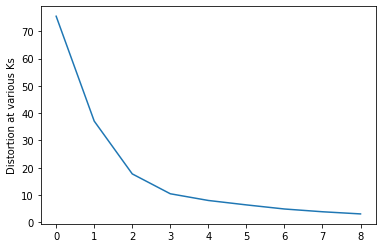

In [324]:
import matplotlib.pyplot as plt

max_k = 10
neighborhoods_clustering = neighborhoods_full_data.drop('Neighborhood', axis =1)

distortion =[]

for i in range(1,max_k):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(neighborhoods_clustering)
    distortion.append(kmeans.inertia_)
    
plt.plot(distortion)
plt.ylabel("Distortion at various Ks")
plt.show()



In [329]:
# Run K Means clustering with k = 4

k = 4

kmeans = KMeans(n_clusters=k,random_state=0).fit(neighborhoods_clustering)


In [331]:
# Add cluster labels to the DF 
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

# Merge DFs to add longitude and latitude information for each neighborhood
map_df = neighborhood_master_df[['Neighborhood','Latitude','Longitude']]
map_df = map_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

map_df = map_df[map_df['Cluster Labels'].notna()]
map_df['Cluster Labels'] = map_df['Cluster Labels'].astype(int)
map_df

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill-Inwood,40.8721,-73.9159,3,Park,Deli / Bodega,Café,Yoga Studio,Train Station,Cuban Restaurant,Playground,Scenic Lookout,Bus Station,Frozen Yogurt Shop
1,Central Harlem North-Polo Grounds,40.816,-73.9432,3,African Restaurant,American Restaurant,Chinese Restaurant,Cosmetics Shop,Bar,Seafood Restaurant,French Restaurant,Fried Chicken Joint,Park,Boutique
2,Hamilton Heights,40.8236,-73.9497,3,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Yoga Studio,Sushi Restaurant,School,Caribbean Restaurant,Sandwich Place
3,Manhattanville,40.8169,-73.9574,0,Coffee Shop,Seafood Restaurant,Mexican Restaurant,Bar,Italian Restaurant,Chinese Restaurant,Scenic Lookout,Gastropub,Boutique,Spanish Restaurant
4,Morningside Heights,40.808,-73.9639,3,Park,Bookstore,Coffee Shop,American Restaurant,Burger Joint,Deli / Bodega,Outdoor Sculpture,Sandwich Place,Supermarket,Food Truck
5,Upper West Side,40.7925,-73.9707,1,Grocery Store,Pizza Place,Mexican Restaurant,Pharmacy,Wine Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Japanese Restaurant,Thrift / Vintage Store
6,Hudson Yards-Chelsea-Flat Iron-Union Square,40.7503,-74.0016,1,Art Gallery,Coffee Shop,Italian Restaurant,Park,Grocery Store,Bookstore,Food Truck,Gym / Fitness Center,Café,Lounge
7,Lincoln Square,40.7735,-73.9853,1,Plaza,Performing Arts Venue,Italian Restaurant,Concert Hall,Theater,Café,Clothing Store,Bakery,French Restaurant,American Restaurant
8,Clinton,40.7591,-73.9961,3,Theater,Gym / Fitness Center,Gym,American Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Cocktail Bar,Wine Shop,Hotel
9,Midtown-Midtown South,40.7516,-73.9852,1,Korean Restaurant,Japanese Restaurant,Bakery,American Restaurant,Clothing Store,Mediterranean Restaurant,Coffee Shop,Hotel,Shoe Store,Salad Place


In [332]:
# Create map using folium
map_clusters = folium.Map(location=[40.758896, -73.985130], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(map_df['Latitude'], map_df['Longitude'], map_df['Neighborhood'], map_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now we have a map showing the 4 clusters of neighborhoods in Manhattan. Recall that our target neighborhoods are West Village, East Village and Midtown-Midtown South. The clusters for those neighborhoods are 1, 3 and 1 respectively. Given that information lets look again at those clusters. 

In [351]:
one = map_df['Cluster Labels'] == 1
three = map_df['Cluster Labels'] == 3
one_df = map_df[one]
three_df = map_df[three]
one_three = one_df.append(three_df)
one_three = one_three[['Neighborhood','Cluster Labels']]
one_three


,Neighborhood,Cluster Labels
5,Upper West Side,1
6,Hudson Yards-Chelsea-Flat Iron-Union Square,1
7,Lincoln Square,1
9,Midtown-Midtown South,1
10,Turtle Bay-East Midtown,1
11,Murray Hill-Kips Bay,1
12,Gramercy,1
14,West Village,1
15,SoHo-TriBeCa-Civic Center-Little Italy,1
19,Lenox Hill-Roosevelt Island,1


### 4. Results and Discussion <a name="results"></a>

___


In [358]:
# Count how many italian restaurants are in each neighborhood and merge with the cluster labels and demographic data

count_italian = italian_df.groupby('Neighborhood').count()[['Venue']]
count_italian = pd.merge(one_three,count_italian, on='Neighborhood').sort_values(by = 'Venue',ascending=True)

count_italian = pd.merge(count_italian, neighborhood_master_df[['Neighborhood','Growth Rate %', 'Median Household Income','Rent % of Income']], on='Neighborhood')
count_italian

,Neighborhood,Cluster Labels,Venue,Growth Rate %,Median Household Income,Rent % of Income
0,Hamilton Heights,3,1,-4.025319,39019,0.063943
1,Washington Heights North,3,1,-8.605034,50192,0.045326
2,Midtown-Midtown South,1,2,10.938893,114491,0.034501
3,SoHo-TriBeCa-Civic Center-Little Italy,1,2,16.282613,118931,0.036996
4,Lenox Hill-Roosevelt Island,1,2,5.402513,98797,0.034363
5,Upper West Side,1,3,-3.341268,92268,0.043135
6,Murray Hill-Kips Bay,1,3,4.797703,97458,0.035892
7,East Village,3,3,5.725099,72665,0.051607
8,Hudson Yards-Chelsea-Flat Iron-Union Square,1,4,25.629041,101369,0.042459
9,Lincoln Square,1,4,11.314470,120337,0.043486


Now that we've found the clusters for similar neighborhoods to our target neighborhoods using a k-means clustering algorithm, when we sort by least amount of Italian restaurants, we can decide which neighborhoods are worth targeting with a new Italian restaurant.

The top two, which are similar to our target neighborhood of East Village, have negative growth rates and lower than average median household incomes, so not worth targeting. Midtown-Midtown South was one of our target neighborhoods so we will ignore that as well, along with Little Italy. So our first suggested neighborhood for our client could be **Lenox Hill-Roosevelt Island**, due to its high pop. growth, and relatively high median household income. **Murray Hill-Kips Bay** and **Hudson Yards-Chelsea-Flatiron-Union Square** are two other options that stand out as being potentially good neighborhoods.

While this analysis was performed using the easiest available data there are several things that could be pursued in further studies. The population data used in this project was based on census data from 2010. Clearly that is dated, and should be updated when the figures for the 2020 census are released in the future. Looking at population growth from almost 20 years ago is stale in terms of what the neighborhood demographics look like today. Another point about the NYC OpenData figures is that the neighborhood tabulation areas limit the dataset to only 25 distinct neighborhoods in Manhattan. As you can see from the names, several of the NTAs include multiple neighborhoods lumped into one large NTA such as the Hudson Yards-Chelsea-Flatiron-Union Square NTA. It would be more helpful to a restaurantuer client to get a more fine grained view into the distinct neighborhoods, to have a higher level of accuracy when picking a location. And finally, the venue data to obtain a count and ratings on Italian restaurants from Foursquare is clearly limited by the free developer account credentials on Foursquare as there are most certainly greater than 65 Italian restaurants in Manhattan. If we were not subject to a rate limit on queries to Foursquare, we could get a fuller dataset of venue ratings (currently a premium API call which is restricted behind higher tiers of accounts). 

### 5. Conclusion <a name="conclusion"></a>

___

Clearly opening a restaurant in a city like New York is a highly competitive undertaking given the prevalence of great restaurants all across the city. Applying a similar approach to the one taken above to provide a potential restauranteur with a more refined view into where restaurants have had success can clearly improve the odds of better financial returns and popularity in NYC.